In [1]:
import pandas as pd

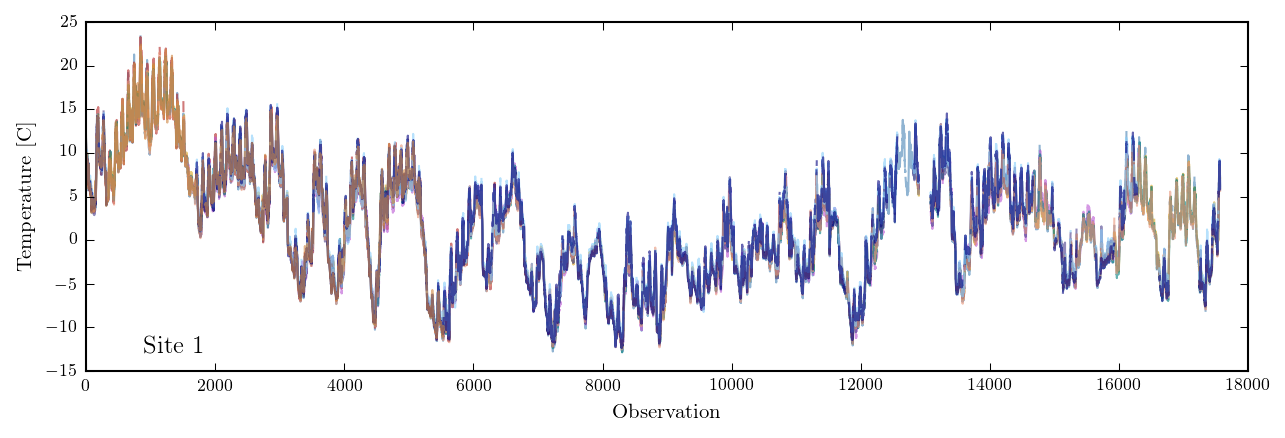

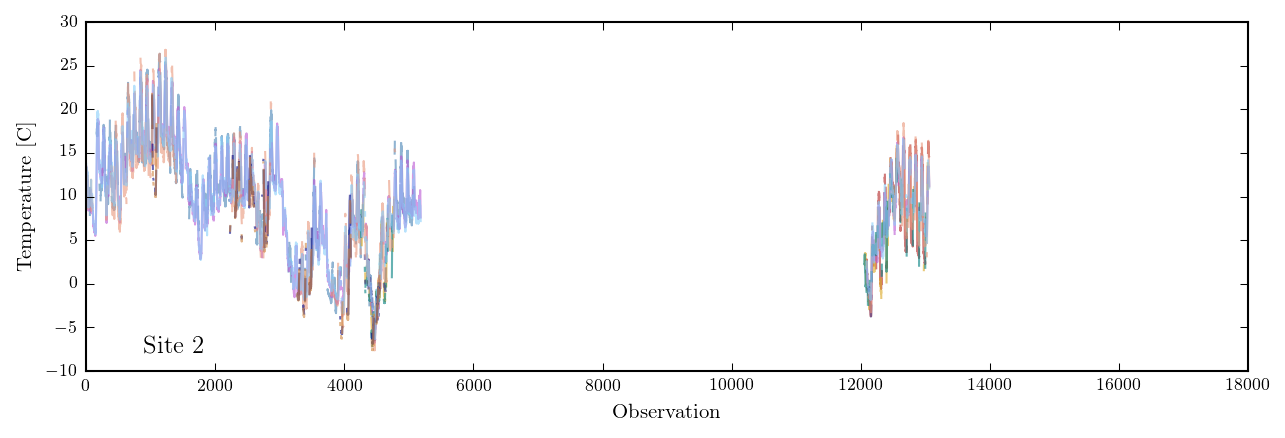

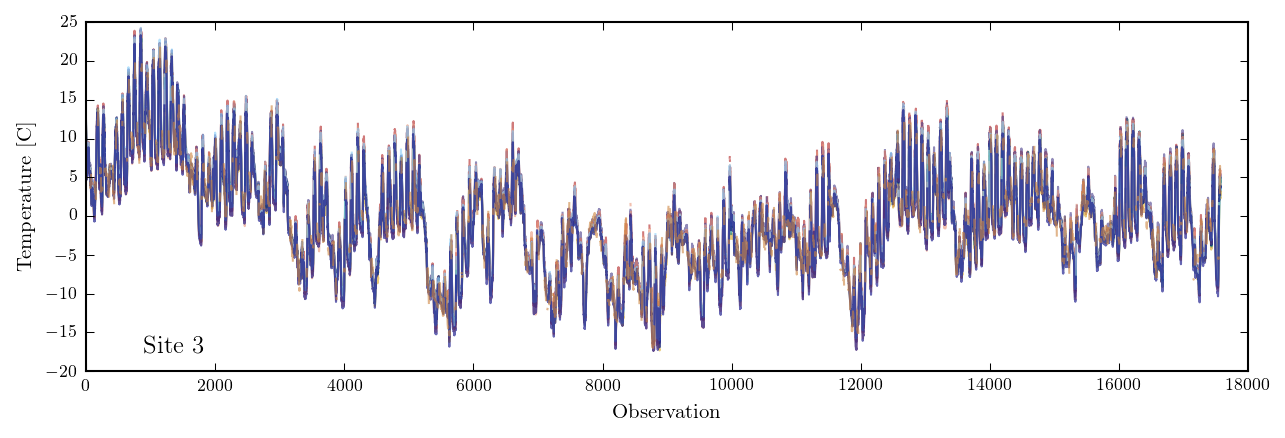

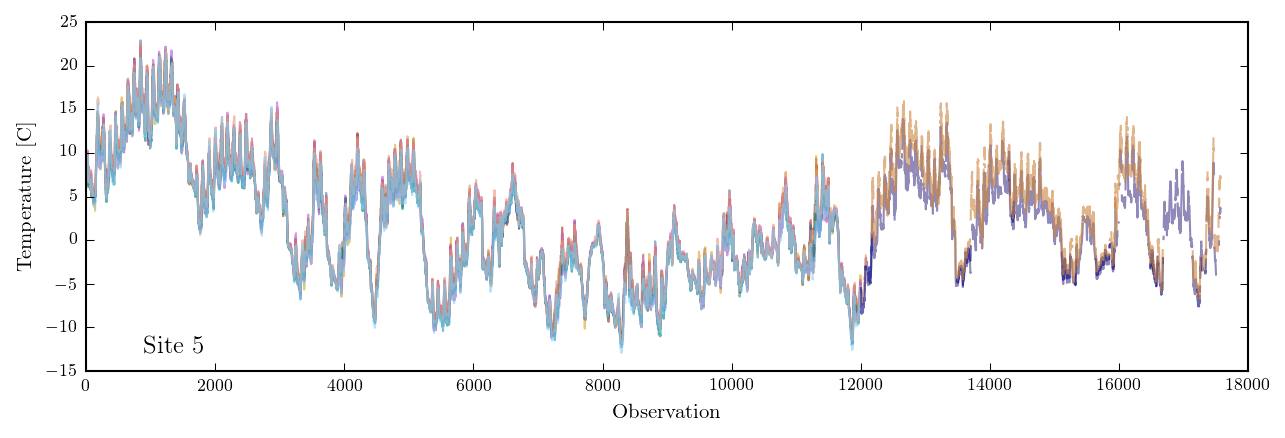

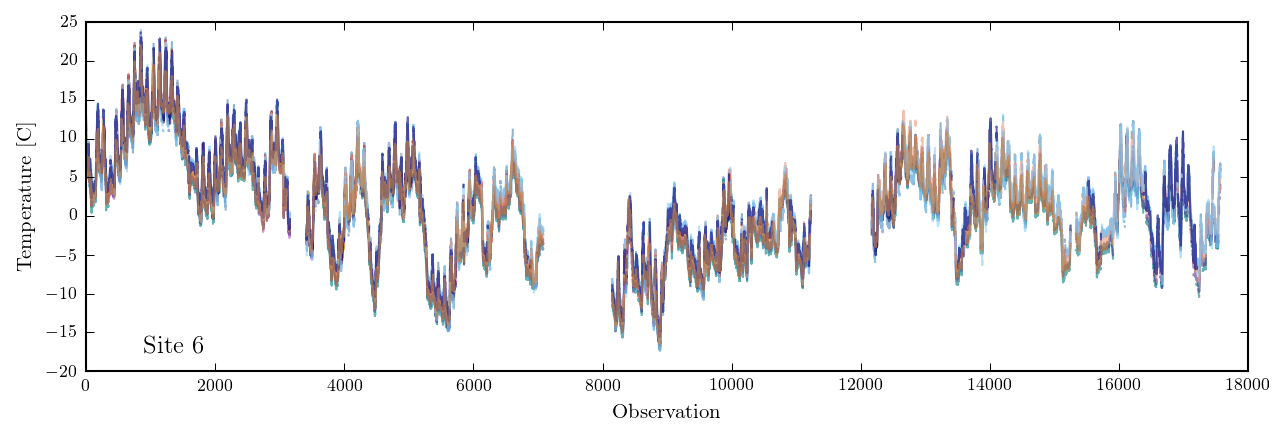

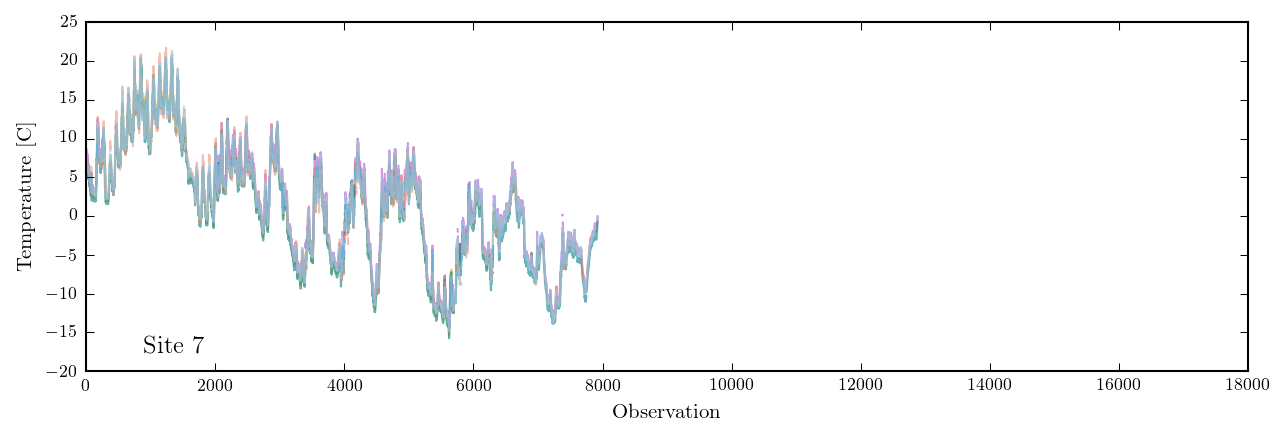

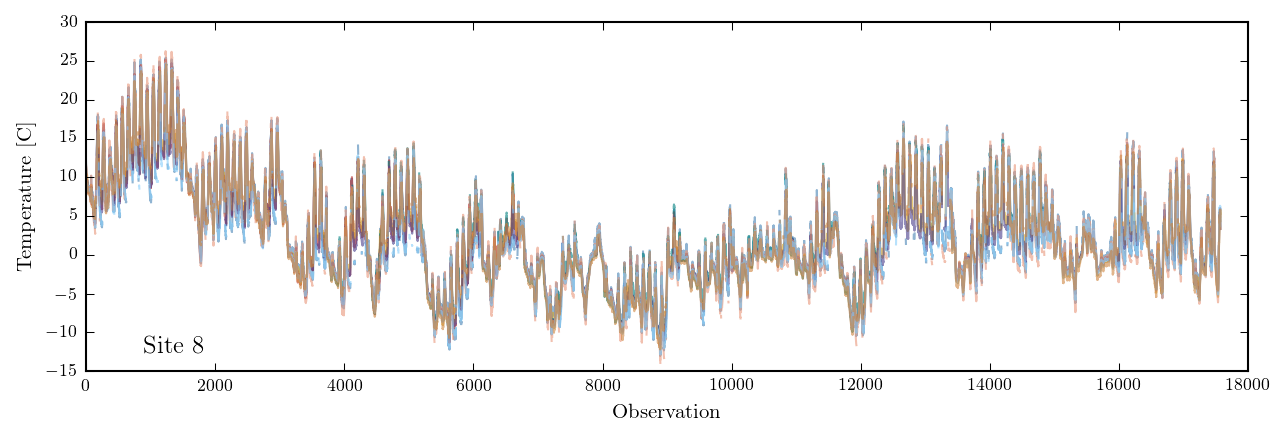

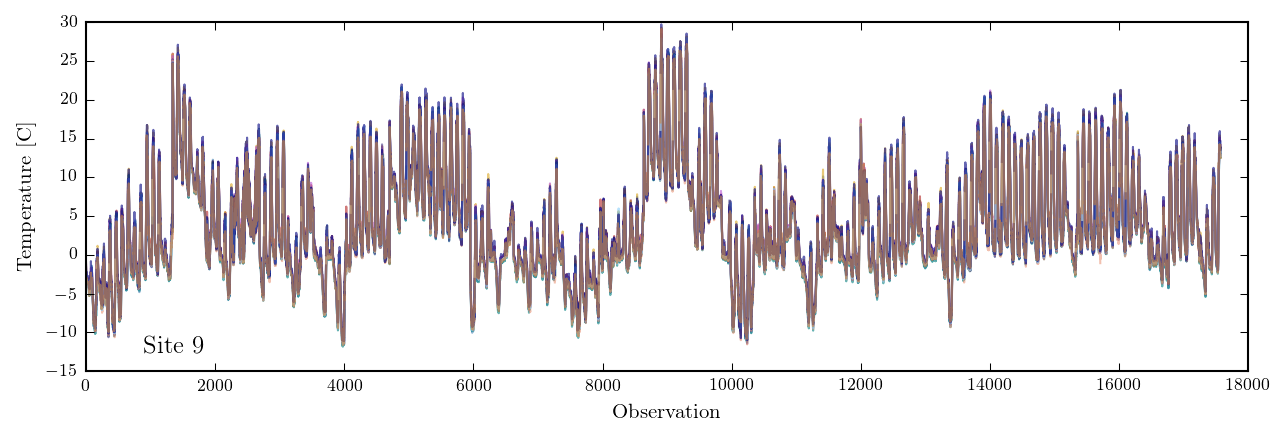

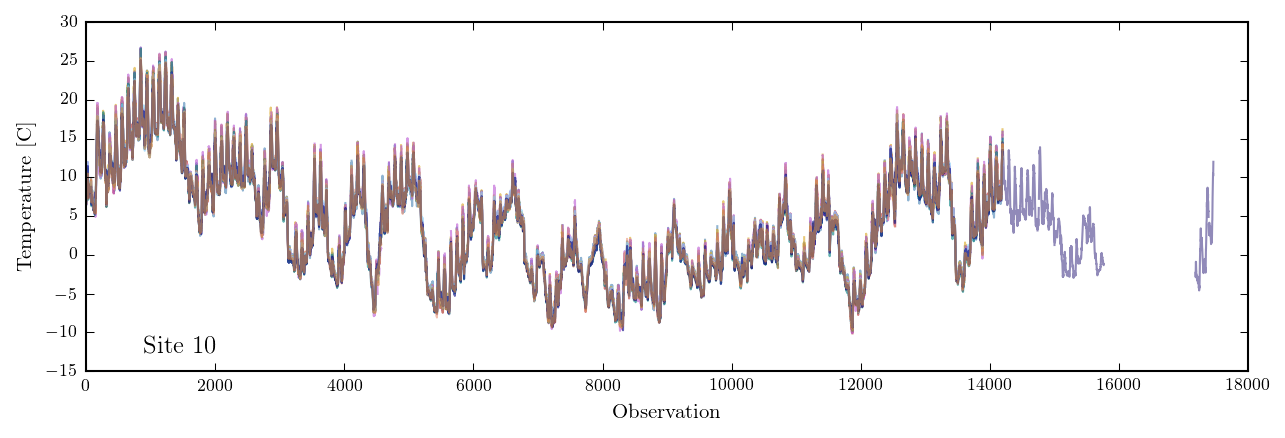

In [174]:
def DifferentialFilter(df, max_diff=2, max_dev=10, max_T=40):
    '''
    Filters the temperature data from the input dataframe in three steps:
      (i) Delete points which change too rapidly over 1 timestep
      (ii) Delete points where the sensor data is more than max_dev deg C from the median of other sensors
      (iii) Delete points where the Temperature is max_T.
    
    Parameters
    ----------
    df : pandas dataframe
        The dataframe containing the temperature data. 
    max_diff : float
        Outliers are any points with more than this differential over a single timestep
    max_dev : float
        Outliers are any points lying more than max_diff degrees C from the median
    max_T : float 
        Temperatures above this value are assumed invalid
    
    Returns
    -------
    df_cleaned : np.array(float)
        dataframe with c
        
    '''
    n_nodes = np.sum([1 for col in df.columns if 'temperature' in col])
    temps=[]
    for i in range(1, n_nodes+1):
        temps.append(df['temperature_%i'%i].values)
    temps=np.array(temps)
    
    df_cleaned = df.copy()
    diff = temps[:,:]-temps[:,:]
    for i in range(n_nodes):
        # If the differential is more than two degrees, it is probably very wrong 
        # This is way above the sensor noise level
        # Set these values to NaN
        idx = np.where(diff[i]>2)[0]
        for i_bad in idx:
            temps[i, i_bad-1:i_bad+1] = np.nan
        
        # If the temp is more than 10 degrees from the median intercluster value, this is ridiculous 
        means = numpy.nanmedian(temps, axis=0)
        diff = np.abs(temps[i]-means)
        temps[i, diff>max_diff] = np.nan
        # Temps above 40c are also not physical.
        temps[i, temps[i]>max_T] = np.nan
        # Write to the cleaned dataframe 
        df_cleaned['temperature_%i'%(i+1)] = temps[i]
        
    return df_cleaned


#------------------------------------------------
# Clean and plot each dataset
for i_site in range(1,11):
    if i_site == 4: 
        continue
        
    plt.figure(figsize=(10,3))
    df = pd.read_csv('../raw_data/site_%i.csv'%i_site)
    df_cleaned = DifferentialFilter(df)   
    df.to_csv('../output/site_%i_cleaned_T.csv'%i_site)

    for i_sensor in range(1,11):
        plt.plot(df_cleaned['temperature_%i'%i_sensor].values, alpha=.6)
    plt.xlim(0, 18000) 
    plt.ylabel('Temperature [C]')
    plt.xlabel('Observation')
    plt.text(.05, .05, 'Site %i'%i_site, transform=plt.gca().transAxes)

